In [2]:
# make a classifier for predicting the gender given the voice features from the kaggle dataset
# https://www.kaggle.com/primaryobjects/voicegender

import pandas as pd
# from sklearn import svm
import torch
from torch import nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# library to plot the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns



## Utils Functions


In [3]:
def print_summary(model_name, y_true, y_pred):
    print(f'{model_name} accuracy: {accuracy_score(y_true, y_pred)}')
    print(f'{model_name} precision: {precision_score(y_true, y_pred)}')
    print(f'{model_name} recall: {recall_score(y_true, y_pred)}')
    print(f'{model_name} f1_score: {f1_score(y_true, y_pred)}')

def preprocess_data():
    df = pd.read_csv('voice.csv')
    X = df.drop('label', axis=1).values
    y = df['label'].values
    y[y=='male']=1
    y[y=='female']=0
    y = y.astype(int)
    scaler = MinMaxScaler((-1,1))
    X = scaler.fit_transform(X)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Preprocess Data

In [4]:
dataset = "https://raw.githubusercontent.com/primaryobjects/voice-gender/master/voice.csv"

def preprocess_data(df):
    df = pd.read_csv(dataset)
    X = df.drop('label', axis=1).values
    y = df['label'].values
    y[y=='male']=1
    y[y=='female']=0
    y = y.astype(int)
    scaler = MinMaxScaler((-1,1))
    X = scaler.fit_transform(X)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

df = pd.read_csv(dataset)
X_train, X_test, y_train, y_test = preprocess_data(df)

## Data Analysis

In [5]:
df.columns

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label'],
      dtype='object')

In [6]:
df.head()

meanfreq        sd    median       Q25       Q75       IQR       skew  \
0  0.059781  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1  0.066009  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2  0.077316  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3  0.151228  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4  0.135120  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   

          kurt    sp.ent       sfm  ...  centroid   meanfun    minfun  \
0   274.402906  0.893369  0.491918  ...  0.059781  0.084279  0.015702   
1   634.613855  0.892193  0.513724  ...  0.066009  0.107937  0.015826   
2  1024.927705  0.846389  0.478905  ...  0.077316  0.098706  0.015656   
3     4.177296  0.963322  0.727232  ...  0.151228  0.088965  0.017798   
4     4.333713  0.971955  0.783568  ...  0.135120  0.106398  0.016931   

     maxfun   meandom    mindom    maxdom   dfrange   modindx  label  
0  0.275862  0.007812  0.007812  0.007812  0.000000  0.000000   male  
1  0.250000  0.009014  0.007812  0.054688  0.046875  0.052632   male  
2  0.271186  0.007990  0.007812  0.015625  0.007812  0.046512   male  
3  0.250000  0.201497  0.007812  0.562500  0.554688  0.247119   male  
4  0.266667  0.712812  0.007812  5.484375  5.476562  0.208274   male  

[5 rows x 21 columns]

In [7]:
df.describe()

meanfreq           sd       median          Q25          Q75  \
count  3168.000000  3168.000000  3168.000000  3168.000000  3168.000000   
mean      0.180907     0.057126     0.185621     0.140456     0.224765   
std       0.029918     0.016652     0.036360     0.048680     0.023639   
min       0.039363     0.018363     0.010975     0.000229     0.042946   
25%       0.163662     0.041954     0.169593     0.111087     0.208747   
50%       0.184838     0.059155     0.190032     0.140286     0.225684   
75%       0.199146     0.067020     0.210618     0.175939     0.243660   
max       0.251124     0.115273     0.261224     0.247347     0.273469   

               IQR         skew         kurt       sp.ent          sfm  \
count  3168.000000  3168.000000  3168.000000  3168.000000  3168.000000   
mean      0.084309     3.140168    36.568461     0.895127     0.408216   
std       0.042783     4.240529   134.928661     0.044980     0.177521   
min       0.014558     0.141735     2.068455     0.738651     0.036876   
25%       0.042560     1.649569     5.669547     0.861811     0.258041   
50%       0.094280     2.197101     8.318463     0.901767     0.396335   
75%       0.114175     2.931694    13.648905     0.928713     0.533676   
max       0.252225    34.725453  1309.612887     0.981997     0.842936   

              mode     centroid      meanfun       minfun       maxfun  \
count  3168.000000  3168.000000  3168.000000  3168.000000  3168.000000   
mean      0.165282     0.180907     0.142807     0.036802     0.258842   
std       0.077203     0.029918     0.032304     0.019220     0.030077   
min       0.000000     0.039363     0.055565     0.009775     0.103093   
25%       0.118016     0.163662     0.116998     0.018223     0.253968   
50%       0.186599     0.184838     0.140519     0.046110     0.271186   
75%       0.221104     0.199146     0.169581     0.047904     0.277457   
max       0.280000     0.251124     0.237636     0.204082     0.279114   

           meandom       mindom       maxdom      dfrange      modindx  
count  3168.000000  3168.000000  3168.000000  3168.000000  3168.000000  
mean      0.829211     0.052647     5.047277     4.994630     0.173752  
std       0.525205     0.063299     3.521157     3.520039     0.119454  
min       0.007812     0.004883     0.007812     0.000000     0.000000  
25%       0.419828     0.007812     2.070312     2.044922     0.099766  
50%       0.765795     0.023438     4.992188     4.945312     0.139357  
75%       1.177166     0.070312     7.007812     6.992188     0.209183  
max       2.957682     0.458984    21.867188    21.843750     0.932374

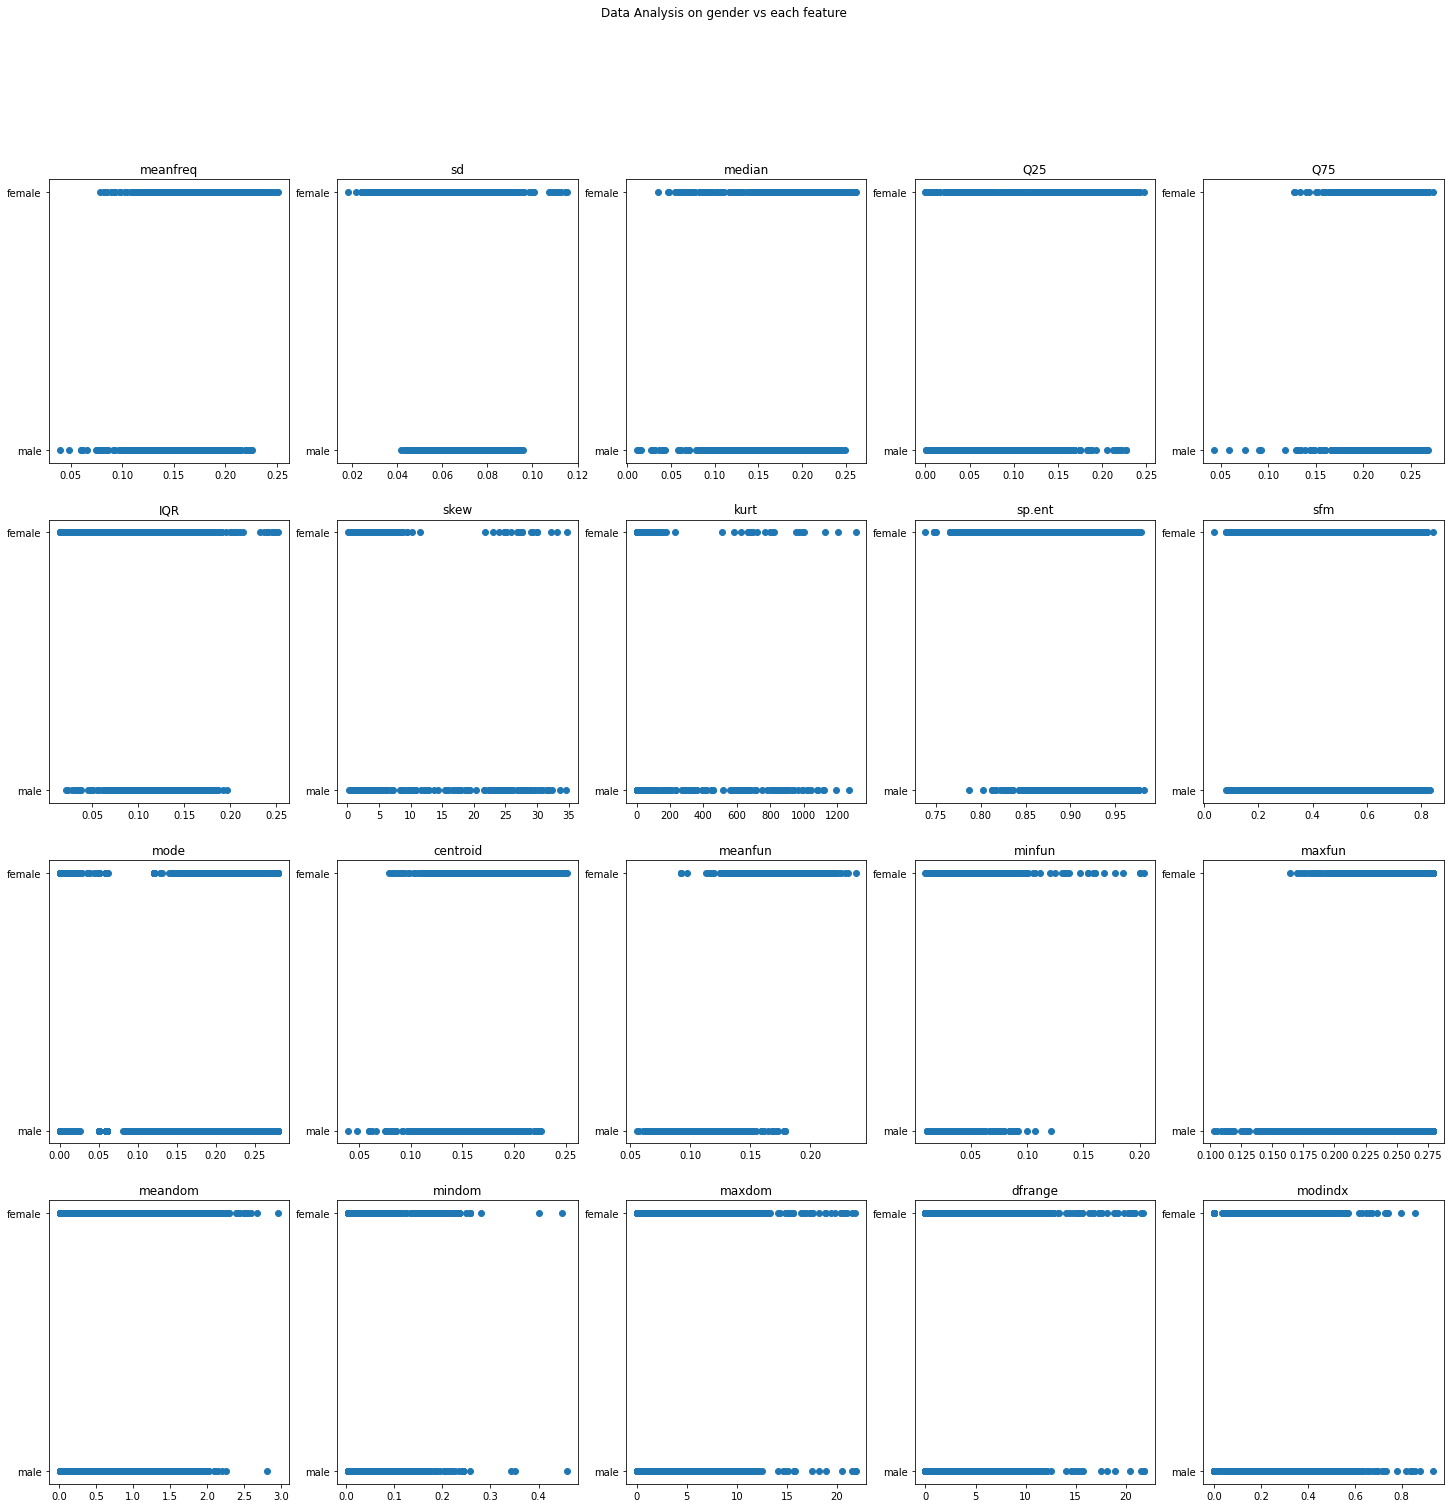

In [15]:
# do some exploratory data analysis on the data with some plots gender vs each feature

i = 1
plt.figure(figsize=(25,24))
for col in df.columns:
    if col != 'label':
        plt.subplot(4,5,i)
        # df.plot.scatter(x=col, y='label', title=col)
        plt.scatter(df[col], df["label"])
        plt.title(col)
        i +=1
plt.suptitle("Data Analysis on gender vs each feature")
plt.show()

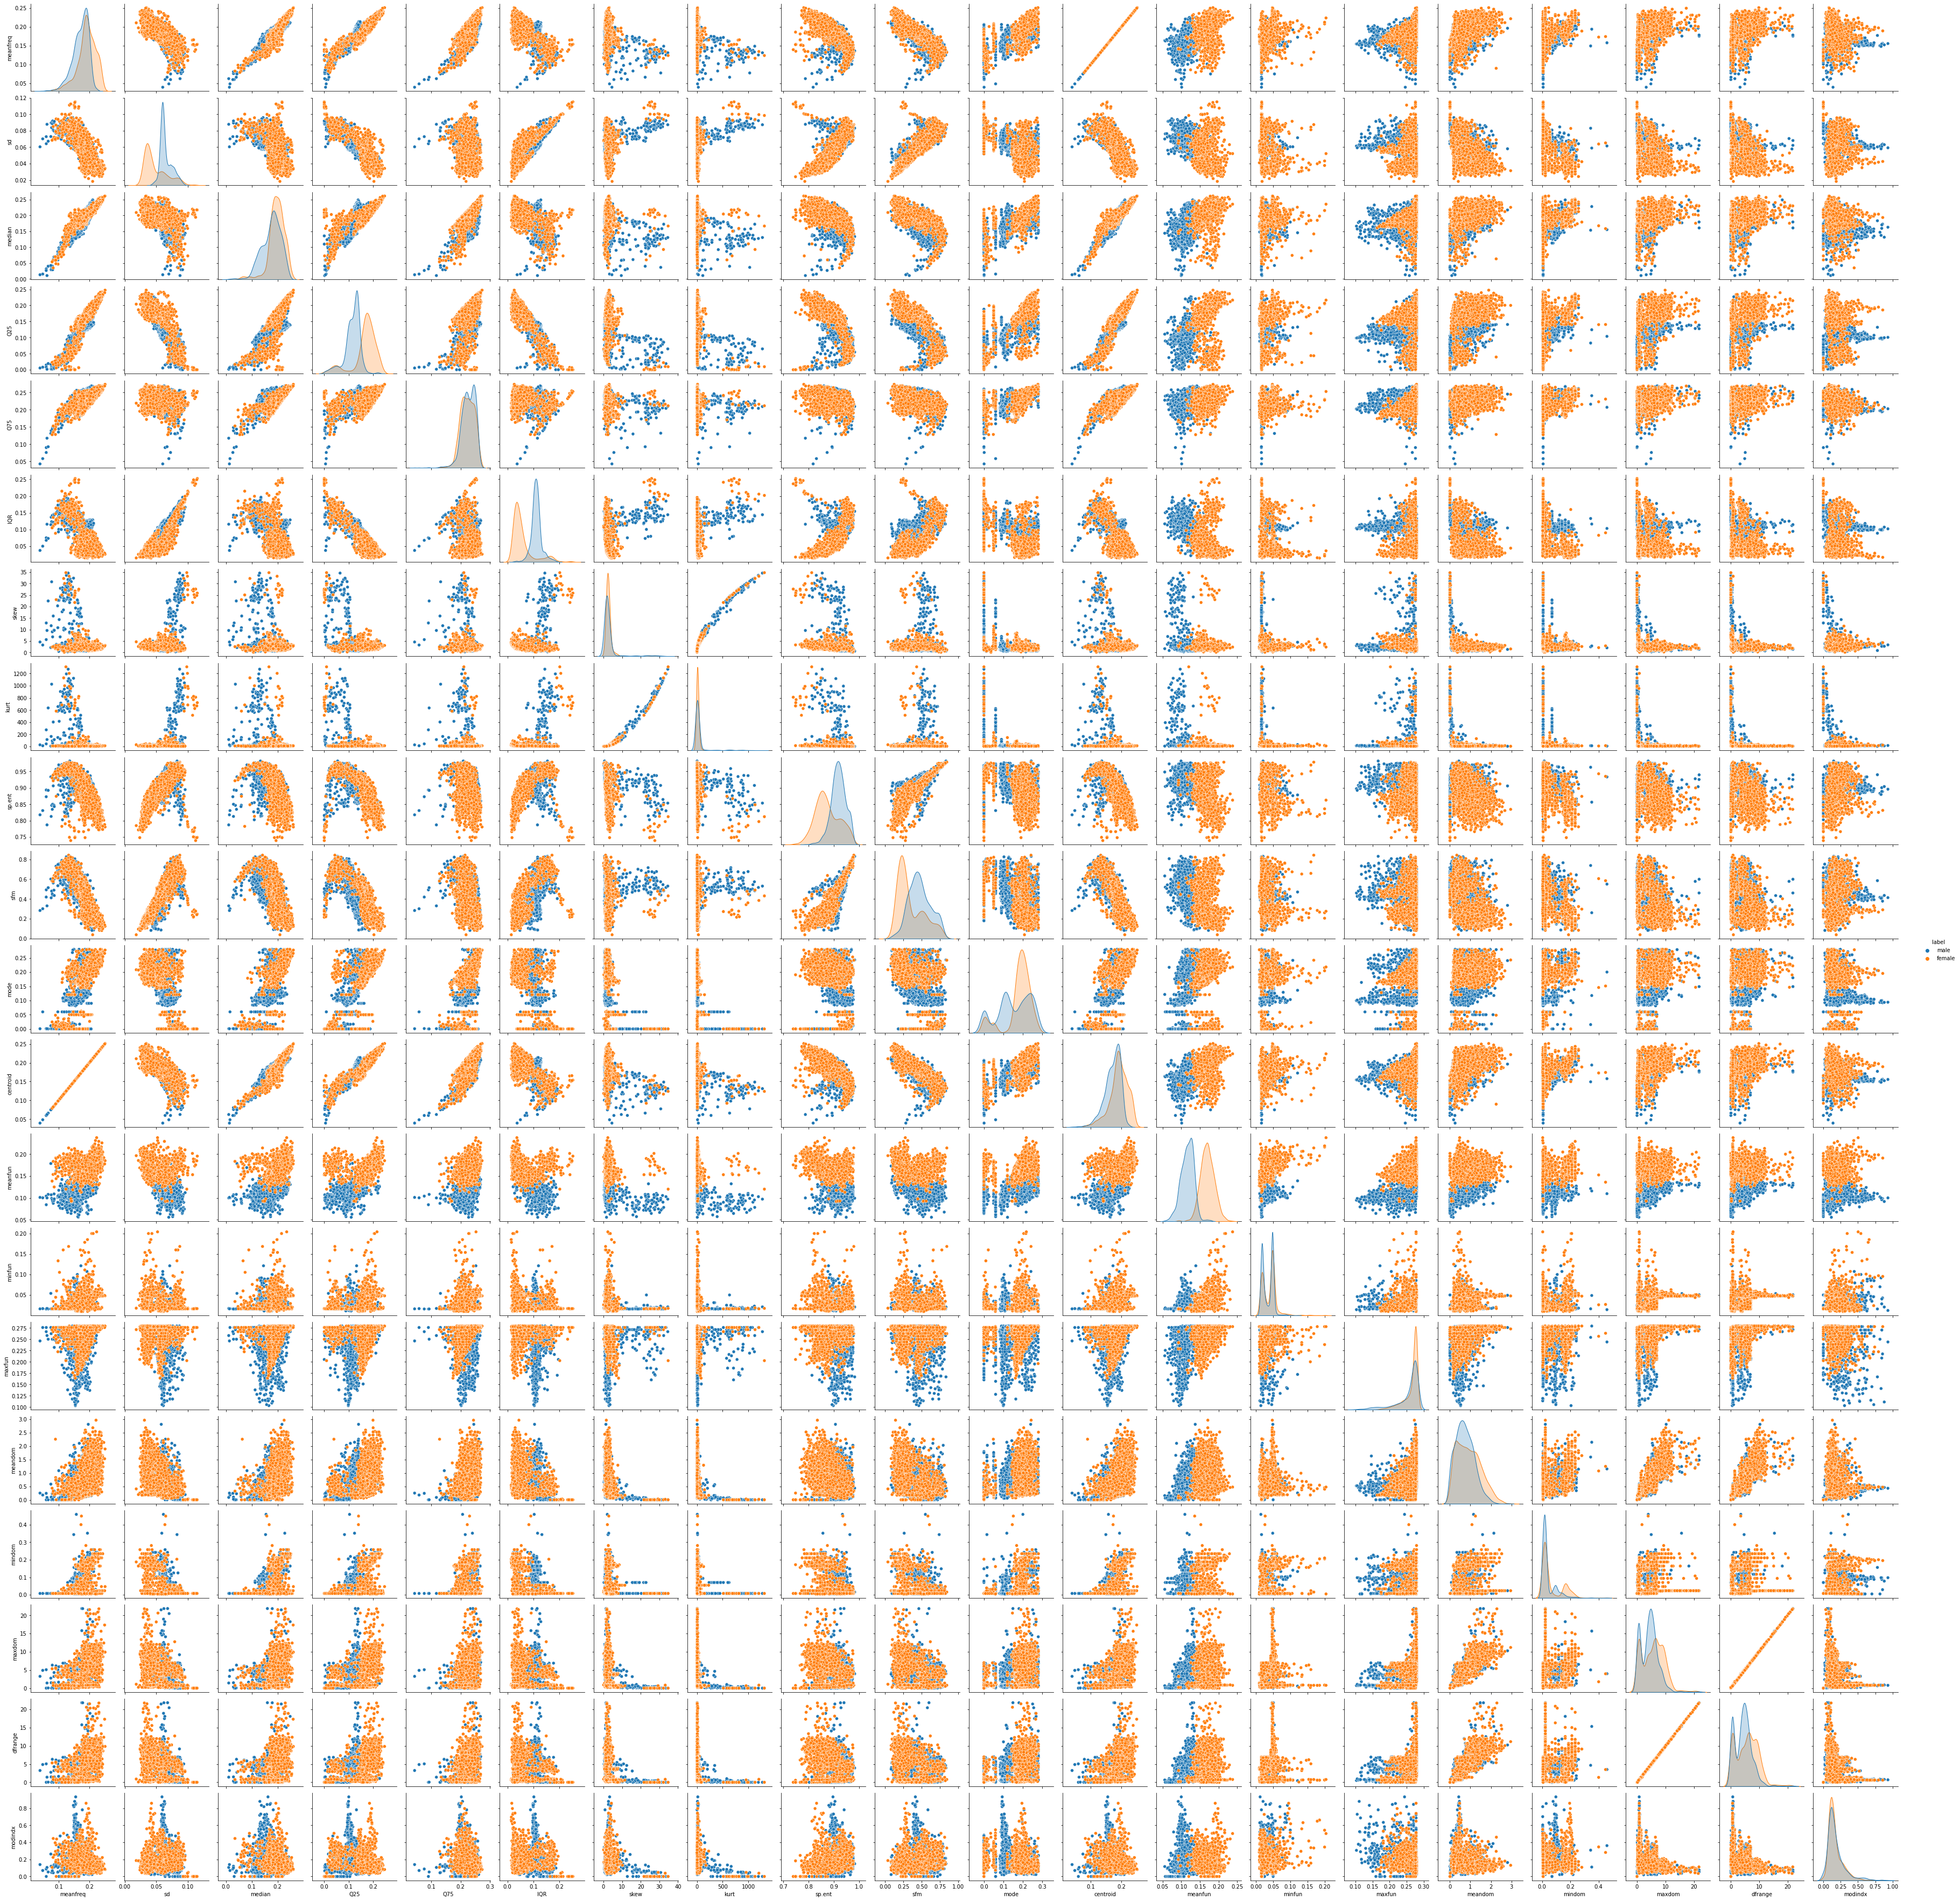

In [9]:
# do some exploratory data analysis on the data with seaborn plots
sns.pairplot(df, hue='label')
plt.show()

# Analysing using different Models

## Neural Net with 2 hidden Layers

### Defining the Model

In [16]:
# now we have the data in the right format, we can start building the model 
# we will use a simple neural network with 2 hidden layers
# we will use the cross entropy loss function and the Adam optimizer
# we will use the accuracy as the metric to evaluate the model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.sigmoid(out)
        out = self.l2(out)
        out = self.sigmoid(out)
        out = self.l3(out)
        out = self.softmax(out)
        return out
    def loss(self, y_pred, y_true):
        loss = y_pred[torch.arange(0, y_true.shape[0]), y_true]
        loss = -torch.sum(loss)
        return loss
    def train(self, X_train, y_train, epochs, learning_rate):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        batch_size = 32
        batches_xtrain = [X_train[i:i+batch_size] for i in range(0, X_train.shape[0], batch_size)]
        batches_ytrain = [y_train[i:i+batch_size] for i in range(0, y_train.shape[0], batch_size)]
        prev_loss = None
        for epoch in range(epochs):
            avg_loss = 0
            for x,y in zip(batches_xtrain, batches_ytrain):
                y_pred = self(X_train)
                loss = self.loss(y_pred, y_train)
                avg_loss += loss.item()
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            if prev_loss is None:
                prev_loss = avg_loss
                continue
            prev_loss = avg_loss
            if prev_loss < avg_loss:
                break

            avg_loss = avg_loss/len(batches_xtrain)
            # print(f'Epoch: {epoch}, Loss: {avg_loss}, Train Accuracy:{self.accuracy(X_train, y_train)}')
        # with torch.no_grad():
        #     y_pred = self(X_test)
        #     y_pred_cls = torch.argmax(y_pred, dim=1)
        #     acc = y_pred_cls.eq(y_test).sum() / float(y_test.shape[0])
        #     print(f'accuracy: {acc:.4f}')
    def predict(self,X):
        with torch.no_grad():
            y_pred = self.forward(X)
            y_pred_cls = torch.argmax(y_pred, dim=1)
            return y_pred_cls
    def accuracy(self, X, y):
        with torch.no_grad():
            y_pred = self.forward(X)
            y_pred_cls = torch.argmax(y_pred, dim=1)
            acc = y_pred_cls.eq(y).sum() / float(y.shape[0])
            # print(f'accuracy: {acc:.4f}')
            return acc



### Training the Model

In [17]:
modelNN = NeuralNet(input_size=20, hidden_size=6)
modelNN.train(X_train, y_train, epochs=60, learning_rate=0.0005)

### Results from the dataset

Neural Net accuracy: 0.9794952681388013
Neural Net precision: 0.9850299401197605
Neural Net recall: 0.9762611275964391
Neural Net f1_score: 0.9806259314456035


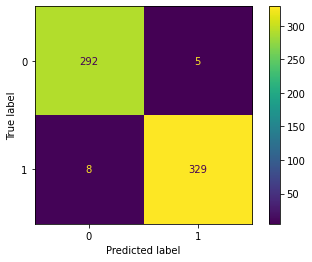

In [12]:
y_pred = modelNN.predict(X_test)
# use sklearn metrics to evaluate the model
print_summary("Neural Net", y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

## SVM Classifier



In [18]:
class SVMClassifier:
    def __init__(self,kernel='rbf', C=1.0, gamma='scale'):
        self.clf = SVC(kernel=kernel, C=C, gamma=gamma)
    def fit(self, X, y):
        self.clf.fit(X, y)
    def predict(self, X):
        return self.clf.predict(X)
    def score(self, X, y):
        return self.clf.score(X, y)

SVM accuracy: 0.9842271293375394
SVM precision: 0.9851632047477745
SVM recall: 0.9851632047477745
SVM f1_score: 0.9851632047477745


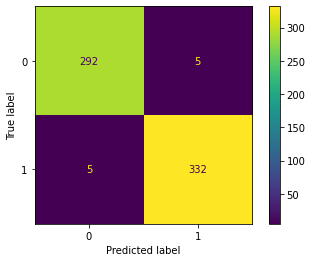

In [19]:
svmmodel = SVMClassifier(kernel='rbf', C=1.0, gamma='scale')
svmmodel.fit(X_train, y_train)
y_pred = svmmodel.predict(X_test)
# print(f'Svm train score {svmmodel.score(X_train, y_train)}')
print_summary("SVM", y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

## Random Forest Classifier

Random Forest accuracy: 0.9810725552050473
Random Forest precision: 0.987987987987988
Random Forest recall: 0.9762611275964391
Random Forest f1_score: 0.982089552238806


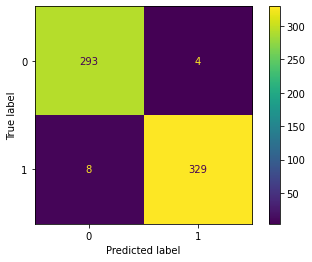

In [20]:
randformodel = RandomForestClassifier()
randformodel.fit(X_train, y_train)
y_pred = randformodel.predict(X_test)
# print(f'Random Forest train score {randformodel.score(X_train, y_train)}')
print_summary("Random Forest", y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
# ConfusionMatrixDisplay(cm).plot()
# display the random forest feature importance plot different from the above plot
ConfusionMatrixDisplay(cm).plot()
plt.show()

### Relative Feature Importance

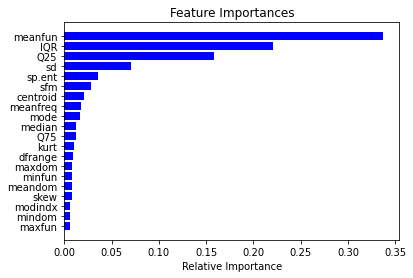

In [41]:
importances = randformodel.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [df.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Decision Tree

Decision Tree accuracy: 0.9747634069400631
Decision Tree precision: 0.9791044776119403
Decision Tree recall: 0.973293768545994
Decision Tree f1_score: 0.9761904761904762


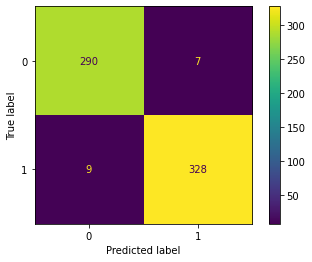

In [21]:
decisiontreemodel = tree.DecisionTreeClassifier(max_depth=3,max_leaf_nodes=6)   
decisiontreemodel.fit(X_train, y_train)
y_pred = decisiontreemodel.predict(X_test)
print_summary("Decision Tree", y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
# print("Decision Tree accuracy is", decisiontreemodel.score(X_test, y_test))

### Visualing the Decision Tree

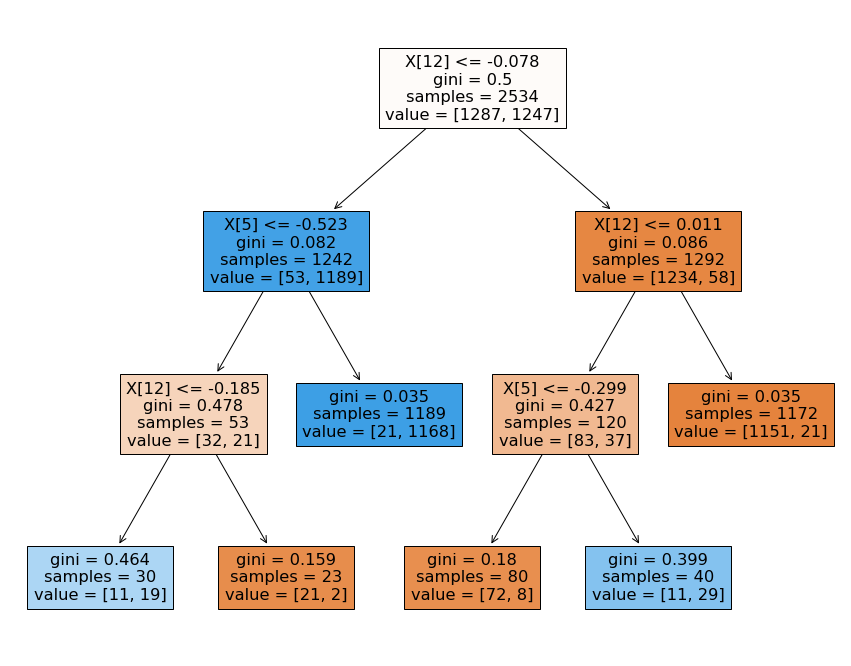

In [44]:
# visualize the decision tree
fig = plt.figure(figsize=(15,12))
_ = tree.plot_tree(decisiontreemodel,filled=True)

## KNN Classifier

KNN accuracy: 0.9794952681388013
KNN precision: 0.9792899408284024
KNN recall: 0.9821958456973294
KNN f1_score: 0.9807407407407408


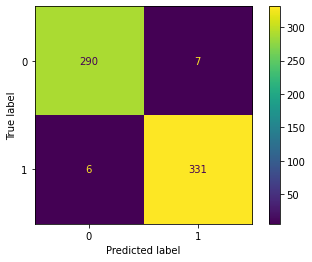

In [22]:
knnmodel = KNeighborsClassifier()
knnmodel.fit(X_train, y_train)
y_pred = knnmodel.predict(X_test)
# print(f'KNN train score {knnmodel.score(X_train, y_train)}')
print_summary("KNN", y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()
# plot the knn classifier with points


## MLP Classifier

MLP accuracy: 0.9826498422712934
MLP precision: 0.9851190476190477
MLP recall: 0.9821958456973294
MLP f1_score: 0.9836552748885588


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


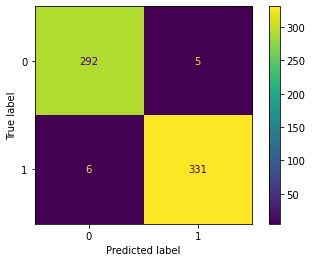

In [23]:
nnmodel = MLPClassifier()
# (hidden_layer_sizes=(40, 40), activation='identity', solver='sgd',
#                        learning_rate='adaptive', max_iter=2000, 
nnmodel.fit(X_train, y_train)
y_pred = nnmodel.predict(X_test)
print_summary("MLP", y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()


## GMM Model

Gaussian Mixture Model accuracy: 0.9605678233438486
Gaussian Mixture Model precision: 0.9727272727272728
Gaussian Mixture Model recall: 0.9525222551928784
Gaussian Mixture Model f1: 0.9625187406296852


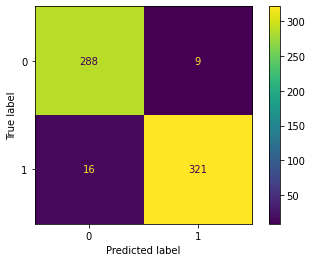

In [53]:
###### GMM model ######

def gmmTrain(X_train, y_train):
    male_features_train= X_train[y_train==1]
    female_features_train = X_train[y_train==0]
    gmm_male = GMM(n_components = 20, max_iter = 200, covariance_type = 'diag', n_init = 3)
    gmm_male.fit(male_features_train)
    gmm_female = GMM(n_components = 20, max_iter=200, covariance_type='diag', n_init = 3)
    gmm_female.fit(female_features_train)
    return [gmm_male, gmm_female]

def gmmPredict(model, X_test):
    modelM, modelF = model
    output = []

    for f in X_test:
        log_likelihood_male = modelM.score(f.reshape(1,-1)).sum()
        log_likelihood_female = modelF.score(f.reshape(1,-1)).sum()

        if log_likelihood_male > log_likelihood_female:
            output.append(1)
        else:
            output.append(0)
    return output


model = gmmTrain(X_train, y_train)
y_pred = gmmPredict(model, X_test)
# print(accuracy_score(y_test,y_pred))
print_summary("Gaussian Mixture Model",y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()
